In [1]:
from IPython.core.display import clear_output
!pip install pennylane --upgrade
clear_output()

In [2]:
!pip install pennylane-qiskit
clear_output()

In [3]:
!pip install pennylane-cirq
clear_output()

In [4]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

In [38]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers

# small size of train and test datasets is caused by time-consumed quantum computations
n_train = 500   # Size of the train dataset
n_test = 100    # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [39]:
# Load CIFAR-10 dataset and split to train/test
cifar_mnist_dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar_mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255


[6]


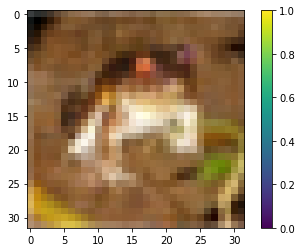

In [7]:
# plot example from dataset
print(train_labels[0])
fig = plt.figure()
plt.imshow(train_images[0, :, :, :])
plt.colorbar()

In [8]:
img_size = train_images.shape[1]

In [9]:
# number of cubits = 4 kernel values * 3 channels
num_cubits = 4 * 3
dev = qml.device('cirq.simulator', wires=num_cubits)

@qml.qnode(dev)
def circuit(phi):
    # encoding of 4 classical input values
    for j in range(num_cubits):
        qml.RY(np.pi * phi[j], wires=j)
    
    # apply hqconv method to realize quantum computations to all 3 channels
    qml.CZ(wires=[0, 3])
    qml.CNOT(wires=[0, 3])

    qml.CZ(wires=[2, 3])
    qml.CNOT(wires=[3, 2])
    
    qml.CZ(wires=[1, 2])
    qml.CNOT(wires=[2, 1])
    
    qml.CZ(wires=[0, 1])
    qml.CNOT(wires=[1, 0])
    
    qml.CZ(wires=[4, 7])
    qml.CNOT(wires=[4, 7])
    
    qml.CZ(wires=[6, 7])
    qml.CNOT(wires=[4, 7])

    qml.CZ(wires=[5, 6])
    qml.CNOT(wires=[6, 5])

    qml.CZ(wires=[4, 5])
    qml.CNOT(wires=[5, 4])

    qml.CZ(wires=[8, 11])
    qml.CNOT(wires=[8, 11])

    qml.CZ(wires=[10, 11])
    qml.CNOT(wires=[11, 10])

    qml.CZ(wires=[9, 10])
    qml.CNOT(wires=[10, 9])

    qml.CZ(wires=[8, 9])
    qml.CNOT(wires=[9, 8])

    qml.CZ(wires=[4, 8])
    qml.CNOT(wires=[4, 8])

    qml.CZ(wires=[0, 4])
    qml.CNOT(wires=[0, 4])

    # measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_cubits)]

In [10]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    q_img_size = int(img_size/2)
    out = np.zeros((q_img_size, q_img_size, num_cubits))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, img_size, 2):
        for k in range(0, img_size, 2):
            # Process a squared 2x2 region of the image with a quantum circuit for each channel
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0],
                 
                    image[j, k, 1],
                    image[j, k + 1, 1],
                    image[j + 1, k, 1],
                    image[j + 1, k + 1, 1],
                 
                    image[j, k, 2],
                    image[j, k + 1, 2],
                    image[j + 1, k, 2],
                    image[j + 1, k + 1, 2]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(12):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
# pre-process train and test images
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
      print("{}/{}        ".format(idx + 1, n_train))
      q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
      print("{}/{}        ".format(idx + 1, n_test))
      q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")
clear_output()

Quantum pre-processing of train images:


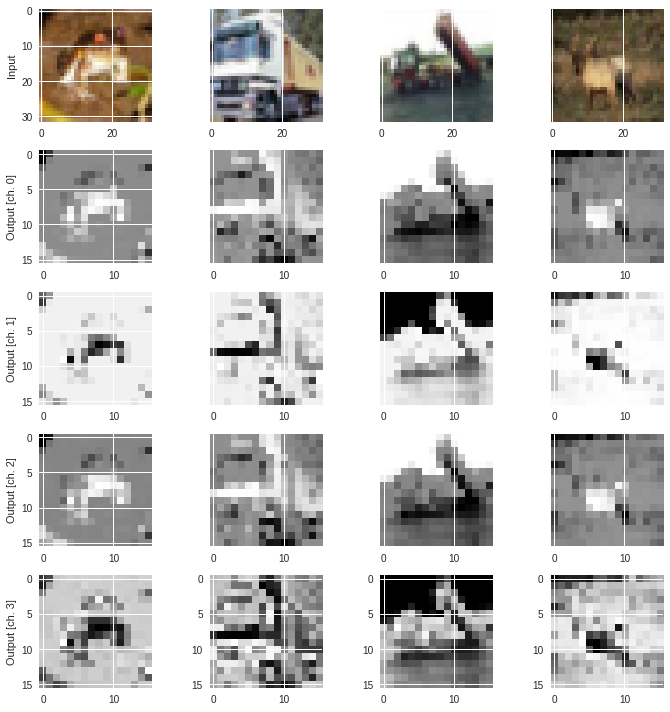

In [85]:
# visualize first 4 channels
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, :])

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c])

plt.tight_layout()
plt.show()

## Convolutional neural network

In [77]:
def conv_model(input_shape):

    model = keras.models.Sequential([
        keras.layers.Input(input_shape),
        keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=1, padding='valid'),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(0.00001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [78]:
q_model = conv_model(q_train_images.shape[1:])

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    epochs=100,
    verbose=0
)

In [79]:
c_model = conv_model(train_images.shape[1:])

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    epochs=100,
    verbose=0
)

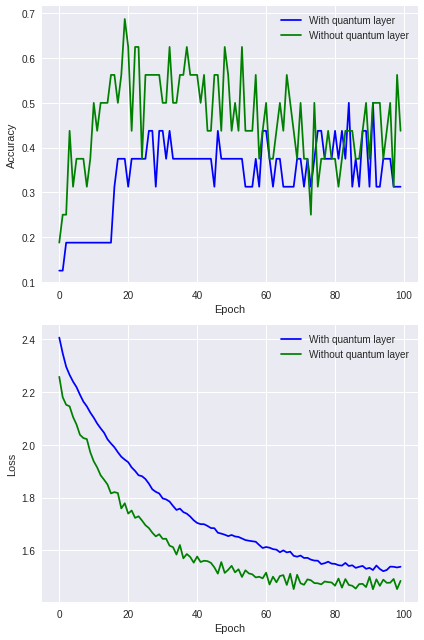

In [80]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-b", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-g", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-b", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-g", label="Without quantum layer")
ax2.set_ylabel("Loss")
# ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

## Dense neural network

In [81]:
def dense_model(input_shape):

    model = keras.models.Sequential([
        keras.layers.Input(input_shape),
        keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(0.00001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [82]:
q_model = dense_model(q_train_images.shape[1:])

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    # batch_size=4,
    epochs=100,
    verbose=0
)

In [83]:
c_model = dense_model(train_images.shape[1:])

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    # batch_size=4,
    epochs=100,
    verbose=0
)

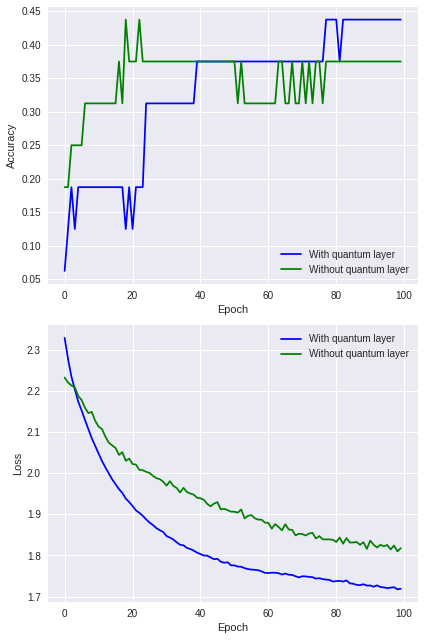

In [84]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-b", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-g", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-b", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-g", label="Without quantum layer")
ax2.set_ylabel("Loss")
# ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()